In [1]:
import numpy as np
import time
import tensorflow as tf
import matplotlib.pyplot as plt
import os, sys
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

# find root directory and add to path
root_index = os.getcwd().rfind('notebooks')
root_directory = os.path.dirname(os.getcwd()[:root_index])
sys.path.append(root_directory)

from MotorNet.plants import RigidTendonArm
from MotorNet.plants.muscles import RigidTendonHillMuscleThelen
from MotorNet.utils.plotor import plot_pos_over_time
from MotorNet.nets.layers import GRUController
from MotorNet.nets.callbacks import BatchLogger, TrainingPlotter
from MotorNet.tasks.tasks import TaskStaticTarget, TaskDelayedReach, TaskDelayedMultiReach

from MotorNet.nets.custommodels import MotorNetModel

%load_ext autoreload
%autoreload 2

# tf.debugging.enable_check_numerics()
print('tensorflow version: ' + tf.__version__)

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2
tensorflow version: 2.5.0-rc0


n_t:  50
Input shape:  (10, 155, 3)
Target shape:  (10, 155, 4)


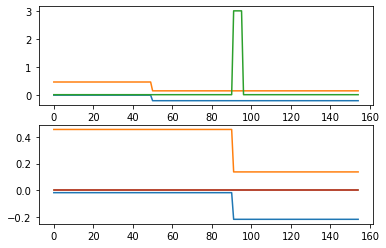

In [2]:
arm = RigidTendonArm(muscle_type=RigidTendonHillMuscleThelen(), proprioceptive_delay=0.04, visual_delay=0.13,
                     excitation_noise_sd=0.001)
feedback_noise = 0.001
# kernel 0, activity 0, recurrent 0
cell = GRUController(plant=arm, n_units=200, kernel_regularizer=10**-5, activity_regularizer=10**-4,
                     recurrent_regularizer=10**-6, name='cell',
                     proprioceptive_noise_sd=feedback_noise, visual_noise_sd=feedback_noise)

task = TaskDelayedMultiReach(arm, cell)
task.delay_range = [30,50]
task.num_target = 1

n_t = int(.5 / arm.dt)
print('n_t: ', n_t)
[inputs, targets, init_states] = task.generate(n_timesteps=n_t, batch_size=10, num_target=2)
print("Input shape: ", inputs.shape)
print("Target shape: " , targets.shape)
fig, axs = plt.subplots(2,1)
axs[0].plot(inputs[0])
axs[1].plot(targets[0])
plt.show()

In [3]:
arm = RigidTendonArm(muscle_type=RigidTendonHillMuscleThelen(), proprioceptive_delay=0.04, visual_delay=0.13,
                     excitation_noise_sd=0.001)
feedback_noise = 0.001
# kernel 0, activity 0, recurrent 0
cell = GRUController(plant=arm, n_units=200, kernel_regularizer=10**-5, activity_regularizer=10**-4,
                     recurrent_regularizer=10**-6, name='cell',
                     proprioceptive_noise_sd=feedback_noise, visual_noise_sd=feedback_noise)

task = TaskDelayedReach(arm, cell)
task.delay_range = [10,80]
task.num_target = 3


# declare inputs
targets = Input((None, arm.state_dim,), name='target')
inputs = Input((None, task.get_input_dim()))
state0 = [Input((arm.state_dim, ), name='joint0'),
          Input((arm.state_dim, ), name='cartesian0'),
          Input((arm.muscle_state_dim, arm.n_muscles, ), name='muscle0'),
          Input((arm.geometry_state_dim, arm.n_muscles, ), name='geometry0'),
          Input((arm.n_muscles*2, arm.proprioceptive_delay, ), name='proprio_feedback0'),
          Input((arm.space_dim, arm.visual_delay, ), name='visual_feedback0')]
state0.extend([Input((n, ), name='gru' + str(k) + '_hidden0') for k, n in enumerate(cell.n_units)])


# wrap cell in an RNN layer
states_out = tf.keras.layers.RNN(cell=cell, return_sequences=True, name='RNN')(inputs, initial_state=state0)
control_rnn = MotorNetModel(inputs=[inputs, state0], outputs=states_out, name='controller')

# pull the losses from the task itself
[losses, loss_weights] = task.get_losses()

# and compile
control_rnn.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001, clipnorm=1.), loss=losses, loss_weights=loss_weights)
batchlog_callback = BatchLogger()
trainingplot_callback = TrainingPlotter(task, plot_freq=100)
control_rnn.summary()
losses

Model: "controller"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 3)]    0                                            
__________________________________________________________________________________________________
joint0 (InputLayer)             [(None, 4)]          0                                            
__________________________________________________________________________________________________
cartesian0 (InputLayer)         [(None, 4)]          0                                            
__________________________________________________________________________________________________
muscle0 (InputLayer)            [(None, 6, 6)]       0                                            
_________________________________________________________________________________________

{'cartesian position': <function MotorNet.nets.losses.position_loss.<locals>.loss(y_true, y_pred)>,
 'muscle state': <function MotorNet.nets.losses.activation_squared_loss.<locals>.loss(y_true, y_pred)>}

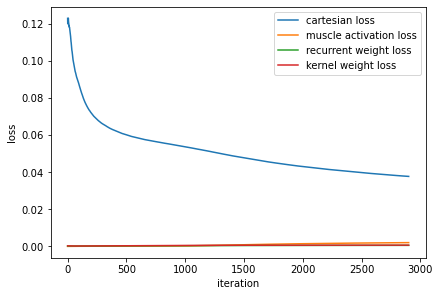

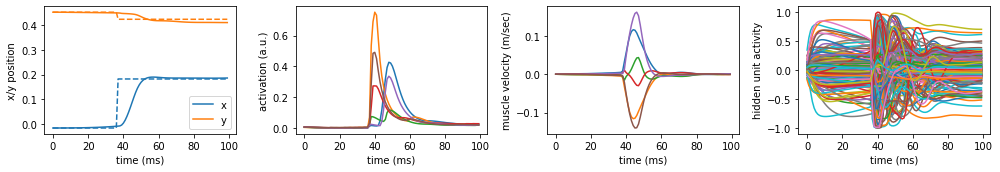

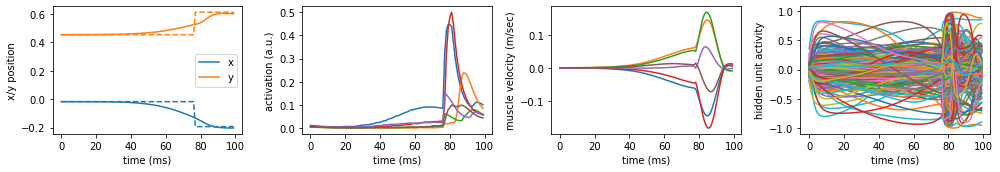

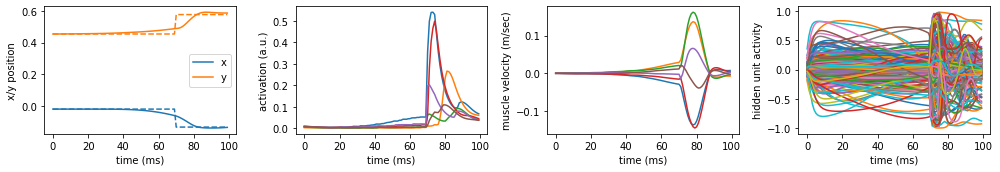

3000/3000 [==============================] - 549s 181ms/step - loss: 0.0529 - RNN_loss: 0.0512 - RNN_4_loss: 0.0047


In [4]:
#name = '50gru_1e-3dt_weights'
#control_rnn.load_weights(os.getcwd() + '/saved_models/' + name)

batch_size = 64
dataset_size = 3000 * batch_size
n_t = int(1 / arm.dt)

with tf.device('/cpu:0'):
    for _ in range(1):
        [inputs, targets, init_states] = task.generate(batch_size=dataset_size, n_timesteps=n_t)
        control_rnn.fit([inputs, init_states], targets, epochs=1, batch_size=batch_size, verbose=1, callbacks=[batchlog_callback, trainingplot_callback], shuffle=False)



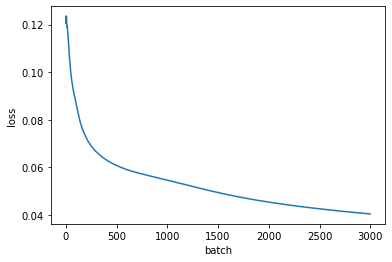

Text(0, 0.5, 'distance to target (y)')

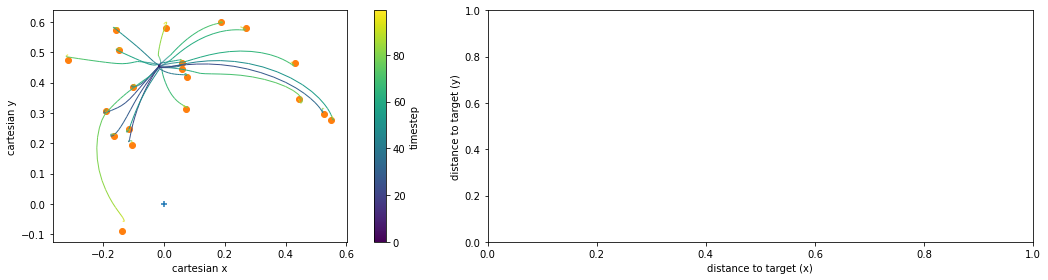

In [5]:
if 'loss' in batchlog_callback.history:
    plt.plot(batchlog_callback.history['loss'])
    plt.xlabel('batch')
    plt.ylabel('loss')
    # plt.semilogy()
    plt.show()

###
with tf.device('/cpu:0'):
    [inputs, targets, init_states] = task.generate(n_timesteps=n_t, batch_size=20)
    results = control_rnn([inputs, init_states], training=False)

j_results = results['joint position']
c_results = results['cartesian position']
m_results = results['muscle state']

plt.figure(figsize=(16, 4)).set_tight_layout(True)
plt.subplot(121)
plot_pos_over_time(cart_results=c_results)
plt.scatter(targets[:, -1, 0], targets[:, -1, 1])


plt.subplot(122)
#plot_pos_over_time(cart_results=c_results - targets)
plt.xlabel('distance to target (x)')
plt.ylabel('distance to target (y)')

(1, 100, 4)


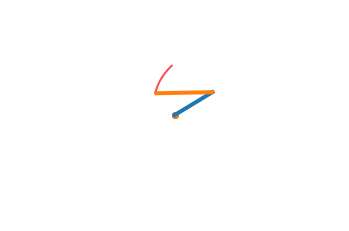

In [6]:
from MotorNet.utils.plotor import animate_arm_trajectory
animate_arm_trajectory(j_results[0:1,:, :], arm)
print(j_results[0:1,:, :].shape)

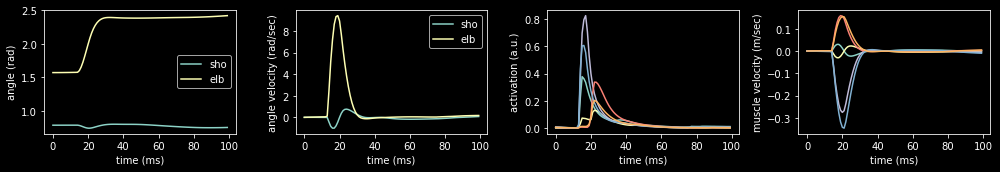

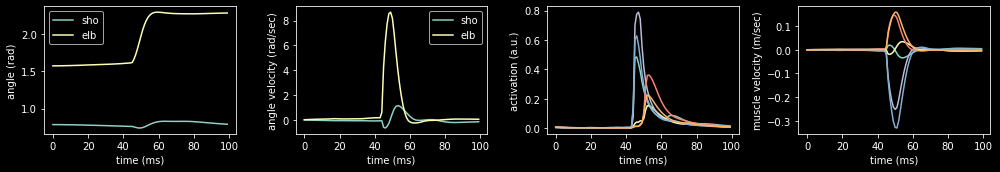

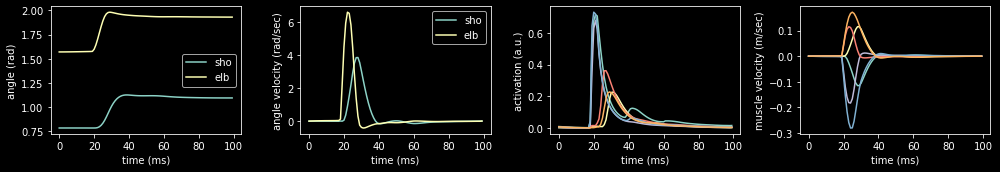

In [7]:
for trial in range(3):
    plt.figure(figsize=(14, 2.5)).set_tight_layout(True)

    plt.subplot(141)
    plt.plot(j_results[trial, :, 0].numpy().squeeze(), label='sho')
    plt.plot(j_results[trial, :, 1].numpy().squeeze(), label='elb')
    plt.legend()
    plt.xlabel('time (ms)')
    plt.ylabel('angle (rad)')

    plt.subplot(142)
    plt.plot(j_results[trial, :, 2].numpy().squeeze(), label='sho')
    plt.plot(j_results[trial, :, 3].numpy().squeeze(), label='elb')
    plt.legend()
    plt.xlabel('time (ms)')
    plt.ylabel('angle velocity (rad/sec)')

    plt.subplot(143)
    plt.plot(m_results[trial, :, 0, :].numpy().squeeze())
    plt.xlabel('time (ms)')
    plt.ylabel('activation (a.u.)')

    plt.subplot(144)
    plt.plot(m_results[trial, :, 2, :].numpy().squeeze())
    plt.xlabel('time (ms)')
    plt.ylabel('muscle velocity (m/sec)')

    plt.show()

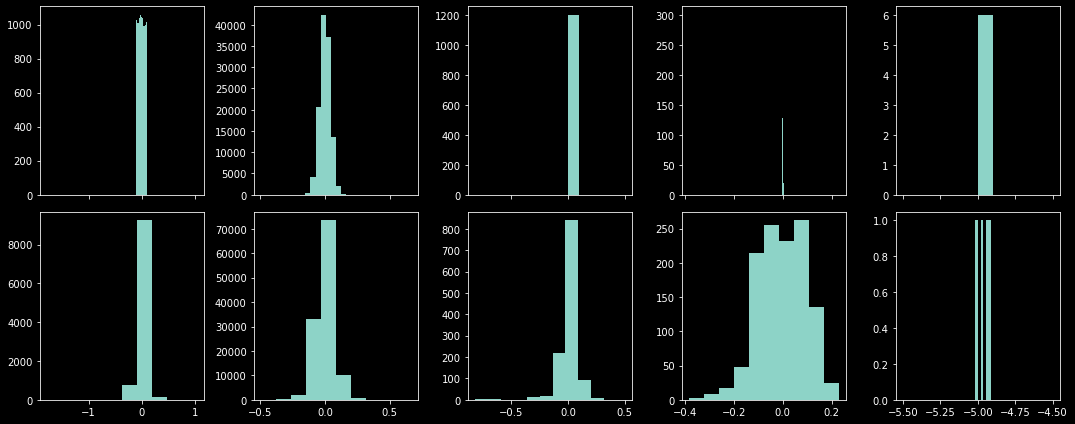

In [8]:
if len(batchlog_callback.weights_log) > 0:
    w0 = batchlog_callback.weights_log[0]
    w1 = batchlog_callback.weights_log[-1]

    fig, axs = plt.subplots(nrows=2, ncols=len(w0), sharex='col')
    fig.set_tight_layout(tight=True)
    fig.set_size_inches((15, 6))

    for n in range(len(w0)):
        weights_ini = w0[n].numpy()
        weights_fin = w1[n].numpy()

        if len(weights_ini.shape) < 10:
            axs[0,n].hist(weights_ini.flatten())
            axs[1,n].hist(weights_fin.flatten())
        else:
            axs[0,n].imshow(weights_ini, interpolation='none')
            axs[1,n].imshow(weights_fin, interpolation='none')

    plt.show()


    
################

### To apply a set of weights from a previous iteration weight set w1
# control_rnn.get_layer('RNN').set_weights([w.numpy() for w in w1])

### save model
# name = '50gru_1e-3dt_weights'
# control_rnn.save_weights(os.getcwd() + '/saved_models/' + name)


In [9]:
import numpy as np
from abc import ABC, abstractmethod
from MotorNet.nets.losses import empty_loss, position_loss, activation_squared_loss
import tensorflow as tf




##################  Grid and Sequence Generator ######################
def GridGen(x_range,y_range,vertex, plot):
    
    # generate the target space with dimensions approximately tgrid_x,tgrid_y
    # one moderately tricky thing is we want 0,0 to be in the grid
    
    xs = np.arange(start=-x_range-.5*3**.5,stop=x_range,step=vertex*3**.5) # beginning x array
    if len(xs) % 2 == 0:  # check number of columns
        xs = xs[1:len(xs)]  # coerce to an odd number of columns
    xs = xs-np.median(xs)  # we want origin at actual 0,0
    
    ys = np.arange(start=-y_range,stop=y_range,step=vertex)
    if len(ys) % 2 == 0:  # check number of rows (half the number actually)
        ys = ys[1:len(ys)]  # coerce to an odd number of columns
    ys = ys-np.median(ys)  # we want origin at actual 0,0
    
    targs = np.zeros((2, len(xs)))  # initialize the targets array
    
    for i in ys:
    
        t_int1 = np.vstack((xs, np.full((1, len(xs)), i)))   # a single row of "major axis" targets

        t_int2 = np.vstack((xs+(vertex/2)*3**.5, np.full((1, len(xs)), i+vertex/2)))  # a single row of "minor axis" targets

        targs = np.hstack((targs, t_int1))
        targs = np.hstack((targs, t_int2))
    
    Grid = np.round(targs[:, len(xs):np.shape(targs)[1]], 3).T
    num_targets = Grid.shape[0]
    
    Grid_dist = np.zeros((num_targets, num_targets))  # Matrix containing pairwise target distanes

    for i in range(num_targets):   # Calculate the euclidean distance for each pair of targets
        for j in range(num_targets):
            Grid_dist[i, j] = np.linalg.norm(Grid[i, :]-Grid[j, :])
            
    # Plots the grid + the center target and its neighbors
    if plot:
        which = np.where(np.logical_and(Grid[:, 0] == 0, Grid[:, 1] == 0) == 1)[0][0]
        neighbor_idx = np.where(np.round(Grid_dist[which, :]) == vertex)[0]
        plt.scatter(Grid[:, 0], Grid[:, 1])
        plt.scatter(Grid[which, 0], Grid[which, 1], color='C3')
        plt.scatter(Grid[neighbor_idx, 0], Grid[neighbor_idx, 1], color='C5')
        plt.show()
    
    return Grid, Grid_dist



# Sequence Generator
def SeqGen(Grid, Grid_dist, seq_length, vertex, plot):
    status = True # Final status of current trial. Is it a successful trial?
    num_targets = Grid.shape[0]
    Trajectory = np.zeros((seq_length,), dtype=np.int)
    Trajectory[0] = np.where(np.logical_and(Grid[:,0]==0 , Grid[:,1]==0)==1)[0]
    epsi = np.finfo(float).eps # Used for neumrical stability of ArcCos
        
    for i in range(seq_length-1):
        if i == 0: # For the first reach
            # Find the neighbors for current possition: Possible targets 
            neighbor_idx = np.where(np.round(Grid_dist[Trajectory[i],:]) == vertex)[0]
            next_idx = np.random.permutation(neighbor_idx)[0]
            Trajectory[i+1] = next_idx
        else:
            # Find the neighbors for current possition: Possible targets 
            neighbor_idx = np.where(np.round(Grid_dist[Trajectory[i],:]) == vertex)[0]


            # Remove the last position from the list
            neighbor_idx = np.delete(neighbor_idx,np.where(neighbor_idx==Trajectory[i-1]))
            # neighbor_idx = np.delete(neighbor_idx,np.where(neighbor_idx==Trajectory[i-2]))

            if len(neighbor_idx) == 0:
                ## print('Ran out of choices')
                status = False
                continue
            
            next_idx = np.random.permutation(neighbor_idx)[0]
            Trajectory[i+1] = next_idx

    return Trajectory, status




In [10]:
Grid, Grid_dist = GridGen(x_range = 4, y_range=4, vertex=1, plot=False)
Trajectory, status = SeqGen(Grid, Grid_dist, seq_length=4, vertex=1, plot=False)
offset = Grid[Trajectory[0],:]